In [2]:
!pip install uproot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 51.2 MB/s eta 0:00:00


In [11]:
import uproot
import awkward as ak

file = uproot.open("576759DA-4A35-534B-B926-2A9E4A5A7268.root")
tree = file["Events"]

branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"]
data = tree.arrays(branches)  # returns awkward array

# Flatten multi-muon events
Muon_pt = ak.flatten(data["Muon_pt"])
Muon_eta = ak.flatten(data["Muon_eta"])
Muon_phi = ak.flatten(data["Muon_phi"])
Muon_charge = ak.flatten(data["Muon_charge"])

# Convert to Pandas if you want
import pandas as pd
df = pd.DataFrame({
    "Muon_pt": Muon_pt,
    "Muon_eta": Muon_eta,
    "Muon_phi": Muon_phi,
    "Muon_charge": Muon_charge
})
print(df.head())


     Muon_pt  Muon_eta  Muon_phi  Muon_charge
0  19.538639 -0.947510  2.702148            1
1  30.923561 -0.074738 -2.494141            1
2  26.081926  1.983643 -2.238770            1
3  30.108654  1.119385 -1.622559            1
4  29.805019 -0.456604  2.101562           -1


1783/1783 ━━━━━━━━━━━━━━━━━━━━ 2s 909us/step
Number of rare/high-energy muons: 2852


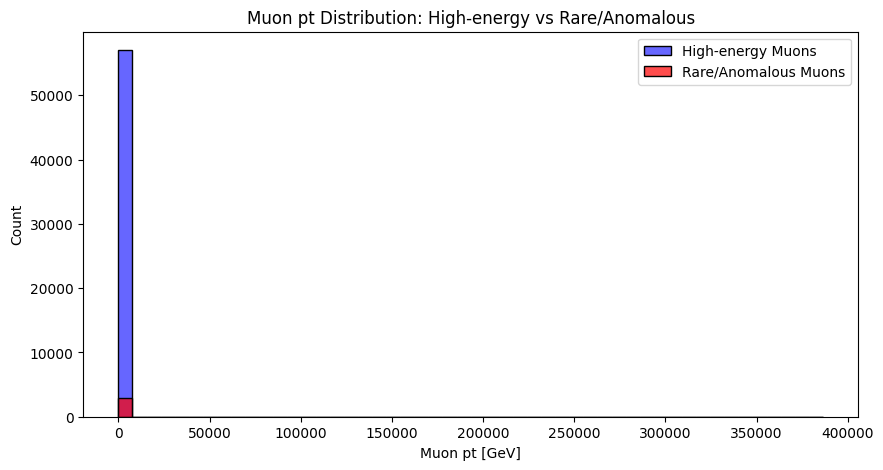

In [12]:
# Step 1: Filter high-energy muons (pt > 20 GeV)
df_highpt = df[df["Muon_pt"] > 20]
X = df_highpt[["Muon_pt", "Muon_eta", "Muon_phi"]].values

# Step 2: Autoencoder for anomaly detection
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
inputs = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(8, activation="relu")(inputs)
decoded = tf.keras.layers.Dense(input_dim, activation="linear")(encoded)
autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_scaled, X_scaled, epochs=15, batch_size=32, verbose=0)

# Step 3: Compute reconstruction error
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - X_pred), axis=1)
threshold = np.percentile(mse, 95)  # top 5% as rare/high-energy
rare_events = df_highpt[mse >= threshold]
print(f"Number of rare/high-energy muons: {len(rare_events)}")

# Step 4: Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_highpt["Muon_pt"], bins=50, color="blue", label="High-energy Muons", alpha=0.6)
sns.histplot(rare_events["Muon_pt"], bins=50, color="red", label="Rare/Anomalous Muons", alpha=0.7)
plt.xlabel("Muon pt [GeV]")
plt.ylabel("Count")
plt.title("Muon pt Distribution: High-energy vs Rare/Anomalous")
plt.legend()
plt.show()


In [13]:
threshold = np.percentile(mse, 99)  # top 1% as rare
rare_events = df_highpt[mse >= threshold]
print(len(rare_events))


571


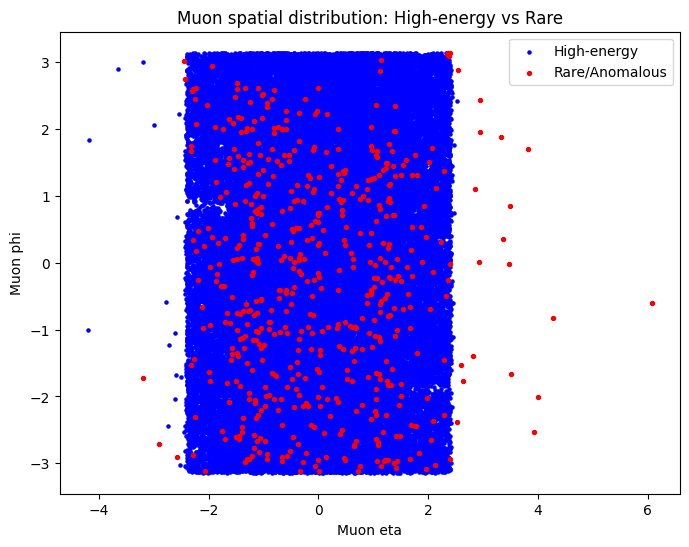

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(df_highpt["Muon_eta"], df_highpt["Muon_phi"], s=5, color="blue", label="High-energy")
plt.scatter(rare_events["Muon_eta"], rare_events["Muon_phi"], s=8, color="red", label="Rare/Anomalous")
plt.xlabel("Muon eta")
plt.ylabel("Muon phi")
plt.title("Muon spatial distribution: High-energy vs Rare")
plt.legend()
plt.show()


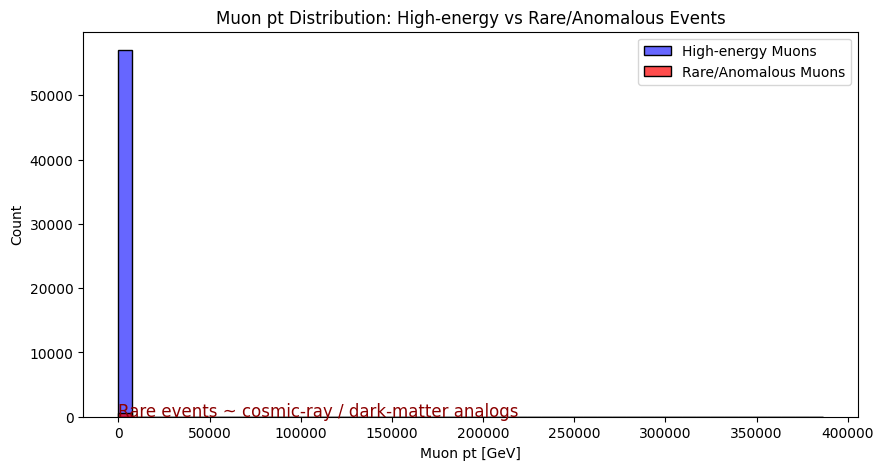

In [17]:
plt.figure(figsize=(10,5))

# 1. Muon pt histogram
sns.histplot(df_highpt["Muon_pt"], bins=50, color="blue", alpha=0.6, label="High-energy Muons")
sns.histplot(rare_events["Muon_pt"], bins=50, color="red", alpha=0.7, label="Rare/Anomalous Muons")

# 2. Add annotation for cosmology analogy
plt.text(50, 30, "Rare events ~ cosmic-ray / dark-matter analogs", fontsize=12, color="darkred")

plt.xlabel("Muon pt [GeV]")
plt.ylabel("Count")
plt.title("Muon pt Distribution: High-energy vs Rare/Anomalous Events")
plt.legend()
plt.show()


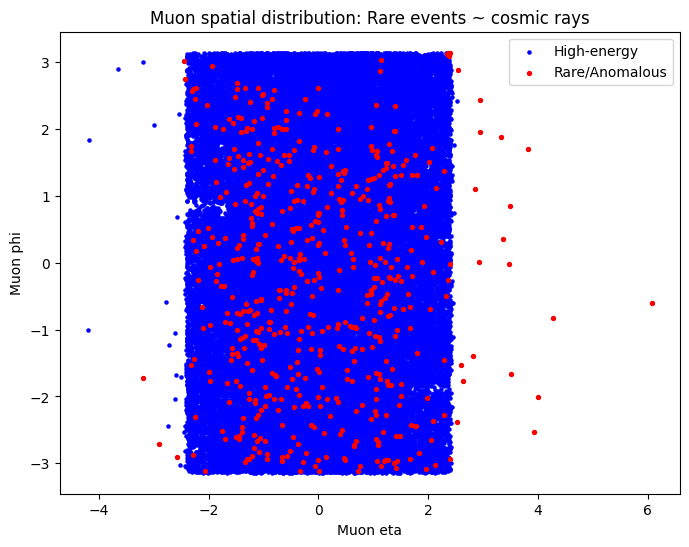

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(df_highpt["Muon_eta"], df_highpt["Muon_phi"], s=5, color="blue", label="High-energy")
plt.scatter(rare_events["Muon_eta"], rare_events["Muon_phi"], s=8, color="red", label="Rare/Anomalous")
plt.xlabel("Muon eta")
plt.ylabel("Muon phi")
plt.title("Muon spatial distribution: Rare events ~ cosmic rays")
plt.legend()
plt.show()



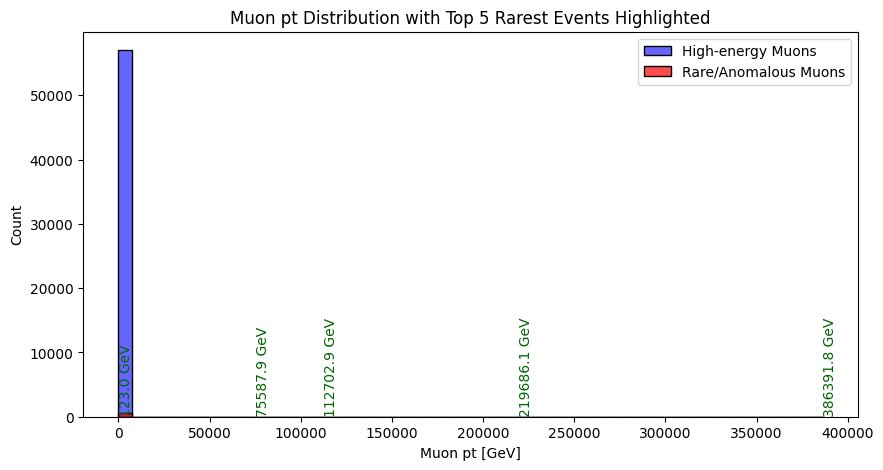

In [19]:
# Step 5b: Highlight top 5 rarest events
top5_idx = np.argsort(mse)[-5:]  # indices of top 5 largest MSE (rarest)
top5_events = df_highpt.iloc[top5_idx]

plt.figure(figsize=(10,5))
sns.histplot(df_highpt["Muon_pt"], bins=50, color="blue", alpha=0.6, label="High-energy Muons")
sns.histplot(rare_events["Muon_pt"], bins=50, color="red", alpha=0.7, label="Rare/Anomalous Muons")

# Annotate top 5 rare events
for i, row in top5_events.iterrows():
    plt.text(row["Muon_pt"], 1, f'{row["Muon_pt"]:.1f} GeV', color="darkgreen", rotation=90, verticalalignment='bottom')

plt.xlabel("Muon pt [GeV]")
plt.ylabel("Count")
plt.title("Muon pt Distribution with Top 5 Rarest Events Highlighted")
plt.legend()
plt.show()



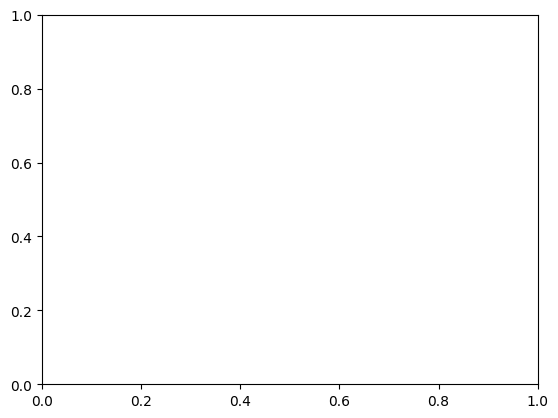

In [20]:
for i, row in top5_events.iterrows():
    plt.annotate(f'{row["Muon_pt"]:.1f} GeV',
                 xy=(row["Muon_pt"], 1),
                 xytext=(row["Muon_pt"], 10),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 color='darkgreen',
                 rotation=0)


<Axes: xlabel='Muon_pt', ylabel='Count'>

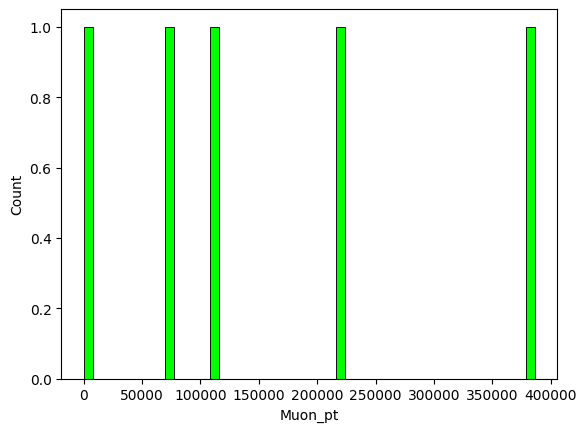

In [21]:
sns.histplot(top5_events["Muon_pt"], bins=50, color="lime", alpha=1.0, label="Top 5 Rare Events")


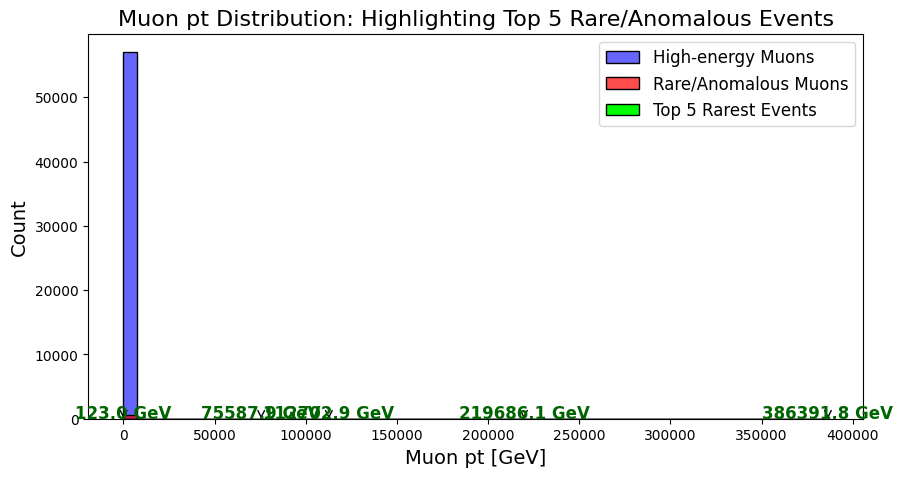

In [22]:
# Highlight top 5 rarest events visually
top5_idx = np.argsort(mse)[-5:]  # indices of top 5 largest MSE
top5_events = df_highpt.iloc[top5_idx]

plt.figure(figsize=(10,5))

# Plot all high-energy muons
sns.histplot(df_highpt["Muon_pt"], bins=50, color="blue", alpha=0.6, label="High-energy Muons")

# Plot rare/anomalous muons
sns.histplot(rare_events["Muon_pt"], bins=50, color="red", alpha=0.7, label="Rare/Anomalous Muons")

# Overlay top 5 rarest events with bright color
sns.histplot(top5_events["Muon_pt"], bins=50, color="lime", alpha=1.0, label="Top 5 Rarest Events")

# Annotate top 5 with arrows
for i, row in top5_events.iterrows():
    plt.annotate(f'{row["Muon_pt"]:.1f} GeV',
                 xy=(row["Muon_pt"], 1),
                 xytext=(row["Muon_pt"], 15),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12,
                 fontweight='bold',
                 color='darkgreen',
                 ha='center')

plt.xlabel("Muon pt [GeV]", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Muon pt Distribution: Highlighting Top 5 Rare/Anomalous Events", fontsize=16)
plt.legend(fontsize=12)
plt.show()


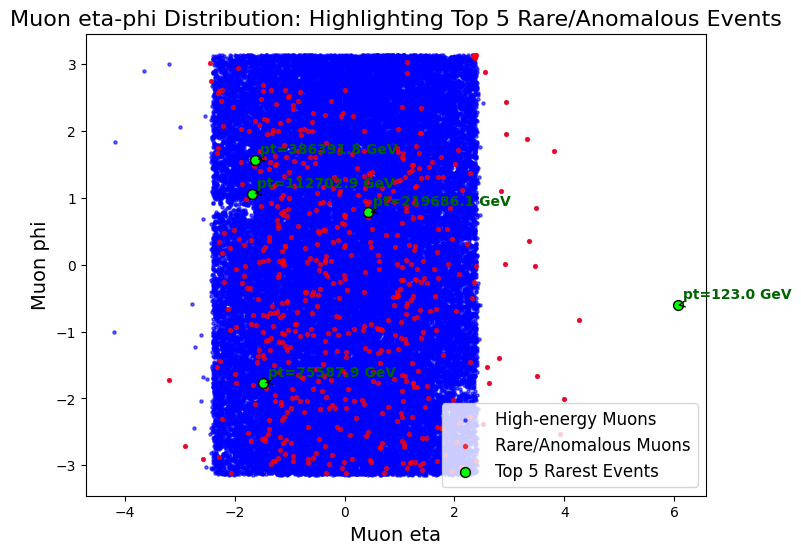

In [23]:
plt.figure(figsize=(8,6))

# All high-energy muons in blue
plt.scatter(df_highpt["Muon_eta"], df_highpt["Muon_phi"], s=5, color="blue", alpha=0.6, label="High-energy Muons")

# Rare/anomalous muons in red
plt.scatter(rare_events["Muon_eta"], rare_events["Muon_phi"], s=8, color="red", alpha=0.7, label="Rare/Anomalous Muons")

# Top 5 rarest muons in lime
plt.scatter(top5_events["Muon_eta"], top5_events["Muon_phi"], s=50, color="lime", edgecolor="black", label="Top 5 Rarest Events")

# Annotate top 5 rarest
for i, row in top5_events.iterrows():
    plt.annotate(f'pt={row["Muon_pt"]:.1f} GeV',
                 xy=(row["Muon_eta"], row["Muon_phi"]),
                 xytext=(row["Muon_eta"]+0.1, row["Muon_phi"]+0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10,
                 fontweight='bold',
                 color='darkgreen')

plt.xlabel("Muon eta", fontsize=14)
plt.ylabel("Muon phi", fontsize=14)
plt.title("Muon eta-phi Distribution: Highlighting Top 5 Rare/Anomalous Events", fontsize=16)
plt.legend(fontsize=12)
plt.show()
